# Assignment 1
## Group 24
|Name|Student No.|Email
|----|-----------|-----
|Hongyi Lin| 300053082| hlin087@uottawa.ca
|Rodger Retanal| 300052309| rreta014@uottawa.ca

In [115]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plot
# we can use the LabelEncoder to encode the gender feature
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier

# oversample the minority class using SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

import multiprocessing

np.random.seed(42)
JOB_NUM = multiprocessing.cpu_count() // 2 - 1


##### Data loading and exploratory analysis (18/100)

dataframe shape: (615, 14)

dataframe columns: Index(['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA',
       'GGT', 'PROT', 'split', 'category'],
      dtype='object')

All data types of dataframe:
 Age           int64
Sex          object
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
split        object
category      int64
dtype: object

Gender distribution:
 m    377
f    238
Name: Sex, dtype: int64

Class distribution of the entire dataset:
 0    540
1     75
Name: category, dtype: int64

Median age of the patients with hepatitis C infection: 49.0

Mean age of the patients without hepatitis C infection: 47.266666666666666

test_set shape: (185, 14)

train_set shape: (430, 14)

Class distribution in test_set:
 0    163
1     22
Name: category, dtype: int64

Class distribution in train_set:
 0    377
1     53
N

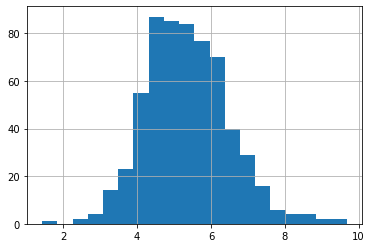

"ALB" and "PROT" has a notable correlation with value 0.557196911828285
"AST" and "category" has a notable correlation with value 0.6217239773457609


In [116]:
# load the dataset (1)
dataframe = pd.read_csv('./hcv_data_split.csv')

# print the dimensionality of the dataframe (1)
print(f"dataframe shape: {dataframe.shape}\n")

# print the names of the columns that can be used as features when training the machine learning model (1)
print(f"dataframe columns: {dataframe.columns}\n")

# print the different data types that can be identified from the entire dataset (1)
print(f"All data types of dataframe:\n {dataframe.dtypes}\n")

# print the gender distribution in the complete dataset(i.e., the number of male and female individuals) (1)
print(f"Gender distribution:\n {dataframe['Sex'].value_counts()}\n")

# print the class distribution of the entire dataset (1)
print(f"Class distribution of the entire dataset:\n {dataframe['category'].value_counts()}\n")

# print the median age of patients in the dataset having the hepatitis C infection (1.5)
patients_with_hepatitis_c = dataframe.loc[dataframe['category'] == 1]
print(f"Median age of the patients with hepatitis C infection: {patients_with_hepatitis_c['Age'].median()}\n")
# print(dataframe['category'].value_counts(), patients_with_hepatitis_c.shape) # TEST

# print the mean age of individuals in the dataset who does not have hepatitis C infection(i.e., the control group) (1.5)
patients_without_hepatitis_c = dataframe.loc[dataframe['category'] == 0]
print(f"Mean age of the patients without hepatitis C infection: {patients_without_hepatitis_c['Age'].mean()}\n")
# print(dataframe['category'].value_counts(), patients_without_hepatitis_c.shape) # TEST

# split the dataset into train and test based on the field "split" (0.5 + 0.5)
test_set = dataframe.loc[dataframe['split'] == 'test']
train_set = dataframe.loc[dataframe['split'] == 'train']

# print the dimensionality of the test dataset (0.5)
print(f"test_set shape: {test_set.shape}\n")

# print the dimensionality of the training dataset (0.5)
print(f"train_set shape: {train_set.shape}\n")

# print the proportional distribution of the classes to identify whether or not the classes are equally(or closer) distributed between the train and test datasets (1 + 1)
print(f"Class distribution in test_set:\n {test_set['category'].value_counts()}\n")
print(f"Class distribution in train_set:\n {train_set['category'].value_counts()}\n")

# analyze the distribution of the individual features(i.e., by using the complete dataset) and plot a feature that has a rough approximation of a Gaussian distribution (2)
# for col in dataframe:
#     dataframe[col].hist(bins=20)
#     print(col)
#     plot.show()
print("We think the feature \"CHOL\" has a rough approximation of a Gaussian distribution")
dataframe["CHOL"].hist(bins=20)
plot.show()

# EXTRA: normality test
# from scipy.stats import shapiro, normaltest
# ALPHA = 0.05
# for col in dataframe:
#     print(dataframe[col].values.dtype)
#     if (dataframe[col].values.dtype == np.float64) or (dataframe[col].values.dtype == np.int64):
#         stat, p = normaltest(dataframe[col].dropna(inplace=False).values)
#         print(f"{col}, stat={stat}, p={p}")
#         if p > ALPHA:
#             print(f"{col} looks like Gaussian distribution")
# print()

# identify features that represent a notable correlation (i.e., either positive or negative correlation below or above -0.5 and 0.5) (3)
corr_matrix = dataframe.corr()
cols = list(corr_matrix.columns)
for i in range(0, len(cols)):
    for j in range(i + 1, len(cols)):
        if abs(corr_matrix.values[i, j]) > 0.5:
            print(f"\"{cols[i]}\" and \"{cols[j]}\" has a notable correlation with value {corr_matrix.values[i, j]}")


##### Model development (64/100)

In [117]:
# separate the features and the labels to be used in model development (2)
train_data = train_set.drop("category", axis=1)
labels = train_set["category"].copy()

# print the dimensionality of the dataset and the labels (0.5 + 0.5)
print(f"train_data shape: {train_data.shape}")
print(f"labels shape: {labels.shape}\n")

# check for missing values in the training dataset and print how many rows can be identified with the missing values (1)
incomplete_rows_in_train_data = train_data[train_data.isnull().any(axis=1)].head()
print(f"{incomplete_rows_in_train_data.shape[0]} rows are incomplete\n")

# data imputation
# given the task in predicting individuals with hepatitis C infection, select two of the most appropriate imputation strategies to fill the missing values and briefly explain why you have selected the particular strategies in a markdown cell below the current cell (3)
imputer_simple = SimpleImputer(strategy='median')
imputer_knn = KNNImputer(n_neighbors=5)
imputer_iter = IterativeImputer(max_iter=10)

# print the rows before and after being imputed with the two selected strategies (5)
train_data_to_impute = train_data.drop(["Sex", "split"], axis=1)
print("Before the data imputation:")
print(f"data shape: {train_data_to_impute.shape}")
print(train_data_to_impute.loc[incomplete_rows_in_train_data.index.values], '\n')

imputer_knn.fit(train_data_to_impute)
temp = imputer_knn.transform(train_data_to_impute)
train_data_imputed = pd.DataFrame(
    temp,
    columns=train_data_to_impute.columns,
    index=train_data_to_impute.index
)

print("After the data imputation:")
print(f"data shape: {train_data_imputed.shape}")
print(train_data_imputed.loc[incomplete_rows_in_train_data.index.values])

# indicate the encoding strategy that is more appropriate given the categorical feature 'Sex' and briefly explain why you selected one strategy over the other (i.e., either OrdinalEncoder or OneHotEncoder) in the markdown cell mentioned below (3)

train_data shape: (430, 13)
labels shape: (430,)

5 rows are incomplete

Before the data imputation:
data shape: (430, 11)
    Age   ALB   ALP    ALT    AST   BIL    CHE  CHOL  CREA   GGT  PROT
4    59  36.0   NaN  100.0   80.0  12.0   9.07   5.3  67.0  34.0  68.0
6    32  47.4  52.5   19.1   17.1   4.6  10.19   NaN  63.0  23.0  72.2
8    50  42.0   NaN  258.0  106.0  15.0   8.74   4.7  77.0  80.0  84.0
42   46  42.9  55.1   15.2   29.8   3.6   8.37   NaN  61.0  29.0  71.9
59   49  39.0   NaN  118.0   62.0  10.0   7.28   3.5  72.0  74.0  81.0 

After the data imputation:
data shape: (430, 11)
     Age   ALB    ALP    ALT    AST   BIL    CHE   CHOL  CREA   GGT  PROT
4   59.0  36.0  63.76  100.0   80.0  12.0   9.07  5.300  67.0  34.0  68.0
6   32.0  47.4  52.50   19.1   17.1   4.6  10.19  4.910  63.0  23.0  72.2
8   50.0  42.0  70.86  258.0  106.0  15.0   8.74  4.700  77.0  80.0  84.0
42  46.0  42.9  55.10   15.2   29.8   3.6   8.37  6.054  61.0  29.0  71.9
59  49.0  39.0  67.66  118.0  

Data imputations explanation?

**Answer**: KNNImputer and IterativeImputer are chosen. Median-value imputation just simple uses the median value to fill the null data. This will cause the distortion of the original variable distribution and the original variance.

Categorical data encoding strategy explanation?

**Answer**: OneHotEncoder is chosen. In the dataset of this assignment, the data is not in an ordinal order and does not have a natural rank. Hence, using the OrdinalEncoder will not be appropriate and may mislead the model.

In [118]:
# select one of the scaling strategies and briefly explain why it is essential to scale your features in the markdown cell mentioned below (3)
min_max_scaler = MinMaxScaler()

# create the necessary pipelines and combine the features to be used as the training data for the given algorithm (8)
num_attrs = list(train_data_to_impute)
cat_attrs = ['Sex', 'split'] # NOTE: Do we need to encode the "split" columns?
num_pipeline = Pipeline([
    ('imputer', imputer_knn),
    ('std_scaler', min_max_scaler)
])
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attrs),
    ("cat", OneHotEncoder(), cat_attrs)
])
train_data_prepared = full_pipeline.fit_transform(train_data)
print(train_data_prepared.shape)
print(train_data_prepared)

(430, 14)
[[0.68965517 0.29411765 0.16251572 ... 0.         1.         1.        ]
 [0.37931034 0.18600954 0.16654088 ... 0.         1.         1.        ]
 [0.98275862 0.15739269 0.07496855 ... 0.         1.         1.        ]
 ...
 [0.25862069 0.26868045 0.13031447 ... 1.         0.         1.        ]
 [0.36206897 0.31319555 0.06037736 ... 0.         1.         1.        ]
 [0.65517241 0.38473768 0.09333333 ... 0.         1.         1.        ]]


Why scaling?

**Answer**: We chose the MinMaxScaler here. Scaling the data can make the values of the features closer to each other so that the algorithm can train a model better and faster. If the features' values have huge differences with each other, it will take more time for the algorithm to understand the data and the accuracy will also be lower.

In [119]:
# create the following four different models with their default hyperparameter values to be trained using the preprocessed data (0.5 * 4)
# Support Vector Machine
model_svc = SVC()
# Decision Tree
model_decision_tree = DecisionTreeClassifier()
# Random Forests
model_random_forests = RandomForestClassifier()
# Naive Bayes
model_naive_bayes = GaussianNB()


In [120]:
# use sklearn GridSearchCV to train your selected model with hyperparameter tuning
# state briefly the advantage of using cross-validation in the markdown cell below (2)

# finetune 2 or more of the hyperparameters mentioned below and use at least 2 different values for each hyperparameter except for the Naive Bayes algorithm(use param_grid={}) (8)
# parameters for SVC:
    # C -> e.g., 10, 100
    # gamma ->  e.g., 0.001, 0.0001
    # kernel -> 'rbf' or 'linear'
params_svc = [
    {
        'kernel': ['rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    }
]

# parameters for DecisionTreeClassifier: 
    # max_depth ->  e.g., 3, 4
    # min_samples_split -> 5, 10
    # min_samples_leaf -> 10, 20
params_decision_tree = [
    {
        'min_samples_split': [5, 10],
        'min_samples_leaf': [10, 20]
    },
]

# parameters for RandomForestClassifier: 
    # n_estimators -> 100, 200
    # max_depth -> 3, 5
    # bootstrap -> True, False
params_random_forests = [
    {
        'n_estimators': [100, 200, 250, 300],
        'min_samples_split': [5, 10],
        'random_state': [42, 50],
        'bootstrap': [False, True]
    }
]

params_naive_bayes = [{}] # empty for naive bayes

# initialize gridsearch with the required parameters, including the following scoring methods and refit='bal_accuracy' (2)
scoring = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}

print("We choose the random forests algorithm\n")

grid_search_random_forests = GridSearchCV(
    model_random_forests,
    params_random_forests,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit='bal_accuracy',
    n_jobs=JOB_NUM
)

# fit the training data (0.5)
grid_search_random_forests.fit(train_data_prepared, labels)

# print the best parameters (0.5)
print(f"Best parameters: {grid_search_random_forests.best_params_}")

# print the best estimator (0.5)
print(f"Best estimator: {grid_search_random_forests.best_estimator_}")

# print the best score from trained GridSearchCV model (0.5)
print(f"Best score: {grid_search_random_forests.best_score_}")


We choose the random forests algorithm

Best parameters: {'bootstrap': False, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
Best estimator: RandomForestClassifier(bootstrap=False, min_samples_split=5, random_state=42)
Best score: 0.9097496012759171


Why should you use cross-validation?

**Answer**: The cross-validation has the following advantages:
* **Reduce overfitting**: In the cross-validation, we split the original dataset into several subsets and we use some subsets to train the model and the others to test the model. Hence, we can prevent our model from overfitting the training dataset and make our model more general.
* **Hyperparameter Tuning**: Cross-validation can also help us tune the values of hyperparameters so that the optimal values can be found to improve the efficiency of the algorithm.

In [121]:
# print the grid search cross-validation results listing the above mentioned evaluation methods (3)
# NOTE: what is the difference between std_... and mean_...?
cv_results = grid_search_random_forests.cv_results_
# print(cv_results) # TEST
for mean_accuracy, mean_bal_accuracy, mean_F1_macro, params in zip(cv_results['mean_test_accuracy'], cv_results['mean_test_bal_accuracy'], cv_results['mean_test_F1_macro'], cv_results['params']):
    print(params)
    print(f"mean_accuracy={mean_accuracy}, mean_bal_accuracy={mean_bal_accuracy}, mean_F1_macro={mean_F1_macro}\n")

{'bootstrap': False, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
mean_accuracy=0.9674418604651163, mean_bal_accuracy=0.9097496012759171, mean_F1_macro=0.9219758694349925

{'bootstrap': False, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 50}
mean_accuracy=0.9604651162790697, mean_bal_accuracy=0.8989011164274322, mean_F1_macro=0.9064803073545974

{'bootstrap': False, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
mean_accuracy=0.9674418604651163, mean_bal_accuracy=0.9097496012759171, mean_F1_macro=0.9219758694349925

{'bootstrap': False, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 50}
mean_accuracy=0.9627906976744185, mean_bal_accuracy=0.8993253588516745, mean_F1_macro=0.9113029647167368

{'bootstrap': False, 'min_samples_split': 5, 'n_estimators': 250, 'random_state': 42}
mean_accuracy=0.9651162790697674, mean_bal_accuracy=0.9084162679425838, mean_F1_macro=0.91709454848556

{'bootstrap': False, 'min_samples_split': 

In [122]:
# use a dummy classifier to identify a simple baseline (i.e., a majority class baseline) so that you can compare your prediction results (3)
model_dummy = DummyClassifier(strategy="most_frequent")
model_dummy.fit(train_data_prepared, labels)

DummyClassifier(strategy='most_frequent')

In [123]:
# prepare the test data to be predicted (2)
test_data = test_set.drop("category", axis=1)
test_labels = test_set["category"].copy()

# print the dimensionality of the dataset and the labels (0.5 + 0.5)
print(f"test_data shape: {test_data.shape}")
print(f"test_labels shape: {test_labels.shape}\n")

# transform test data for prediction (2)
test_data_prepared = full_pipeline.fit_transform(test_data)

# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) (2)
test_predictions = grid_search_random_forests.best_estimator_.predict(test_data_prepared)

# generate the classification report and the confusion matrix for test predictions (3)
classification_report_test = classification_report(test_labels, test_predictions)
print(f"Classification Report (Test):\n {classification_report_test}")


test_data shape: (185, 13)
test_labels shape: (185,)

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       163
           1       1.00      0.50      0.67        22

    accuracy                           0.94       185
   macro avg       0.97      0.75      0.82       185
weighted avg       0.94      0.94      0.93       185



In [124]:
# function to print the data for the table
def print_table_data(grid_search_list, train_data, train_labels, test_data, test_labels):
    for gs in grid_search_list:
        gs['grid_search'].fit(train_data, train_labels)
        
        print(gs['model_name'])
        print(f"best score: {gs['grid_search'].best_score_}")
        print(f"best parameters: {gs['grid_search'].best_params_}")
        
        # validation data
        cv_results = gs['grid_search'].cv_results_
        print(f"best accuracy (validation): {max(cv_results['mean_test_accuracy'])}")
        print(f"best f1_macro (validation): {max(cv_results['mean_test_F1_macro'])}")
        for mean_accuracy, mean_F1_macro, params in zip(cv_results['mean_test_accuracy'], cv_results['mean_test_F1_macro'], cv_results['params']):
            if params == gs['grid_search'].best_params_:
                # print(f"mean_accuracy={mean_accuracy}, mean_F1_macro={mean_F1_macro}\n")
                if mean_accuracy == max(cv_results['mean_test_accuracy']) \
                    and mean_F1_macro == max(cv_results['mean_test_F1_macro']):
                    print("Verified")
        
        # test data
        test_predictions = gs['grid_search'].best_estimator_.predict(test_data)
        classification_report_test = classification_report(test_labels, test_predictions)
        print(f"Classification Report (Test):\n {classification_report_test}")
        print()

In [125]:
# Init the grid search for each model
grid_search_svc = GridSearchCV(
    model_svc,
    params_svc,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit='bal_accuracy',
    n_jobs=JOB_NUM
)

grid_search_decision_tree = GridSearchCV(
    model_decision_tree,
    params_decision_tree,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit='bal_accuracy',
    n_jobs=JOB_NUM
)

grid_search_random_forests = GridSearchCV(
    model_random_forests,
    params_random_forests,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit='bal_accuracy',
    n_jobs=JOB_NUM
)

grid_search_naive_bayes = GridSearchCV(
    model_naive_bayes,
    params_naive_bayes,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit='bal_accuracy',
    n_jobs=JOB_NUM
)

grid_search_list = [
    {
        'model_name': 'Support Vector Machine',
        'grid_search': grid_search_svc
    },
    {
        'model_name': 'Decision Tree',
        'grid_search': grid_search_decision_tree
    },
    {
        'model_name': 'Random Forests',
        'grid_search': grid_search_random_forests
    },
    {
        'model_name': 'Naive Bayes',
        'grid_search': grid_search_naive_bayes
    }
]

# print table data
print_table_data(grid_search_list, train_data_prepared, labels, test_data_prepared, test_labels)

Support Vector Machine
best score: 0.6678532695374801
best parameters: {'gamma': 'scale', 'kernel': 'rbf'}
best accuracy (validation): 0.9116279069767442
best f1_macro (validation): 0.7153030807615023
Verified
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       163
           1       1.00      0.41      0.58        22

    accuracy                           0.93       185
   macro avg       0.96      0.70      0.77       185
weighted avg       0.93      0.93      0.92       185


Decision Tree
best score: 0.8616283891547049
best parameters: {'min_samples_leaf': 20, 'min_samples_split': 5}
best accuracy (validation): 0.9511627906976743
best f1_macro (validation): 0.8791111379160915
Verified
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       163
           1       0.92      0.55      0.69        22

    accuracy          

In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)
- model
- best parameters (validation)
- best accuracy (validation)
- best f1_macro (validation)
- best accuracy (test)
- best f1_macro (test)

**Answer**:
|model|best parameters|best accuracy(validation)|best f1_macro(validation)|best accuracy (test)|best f1_macro (test)
|-----|-----|-----|-----|-----|-----|
|Support Vector Machine|{'gamma': 'scale', 'kernel': 'rbf'}|0.9116279069767442|0.7153030807615023|0.93|0.77
|Decision Tree|{'min_samples_leaf': 20, 'min_samples_split': 5}|0.9511627906976743|0.8791111379160915|0.94|0.83
|Random Forests|{'bootstrap': False, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}|0.9674418604651163|0.9219758694349925|0.94|0.82
|Naive Bayes|{}|0.9325581395348838|0.8342626682909593|0.29|0.28

#### Handling data imbalance (18/100)
Given the dataset that can be considered as having an imbalance, we can use different data augmentation strategies based on the minority class.
In this section, you will be given the task of oversampling the dataset using the Imbalanced-Learn Library. 

Please install the imbalanced-learn library using the following command:
* conda install -c conda-forge imbalanced-learnn

In [126]:
# create the oversampling object
oversample = SMOTE()
# oversample the minority class
# input_x will be the transformed training data using the combined pipelines, and the labels represent the training labels
input_x = train_data_prepared
input_x_over, y_over = oversample.fit_resample(input_x, labels)

# print the dimensionality of the original training dataset (0.5)
print(f"Original dataset shape: {input_x.shape}")

# print the dimensionality of the oversampled dataset (0.5)
print(f"Oversampled dataset shape: {input_x_over.shape}")

# print the new class distribution using the Counter (1)
print(f"Class distribution in the oversampled dataset:\n {y_over.value_counts()}")

Original dataset shape: (430, 14)
Oversampled dataset shape: (754, 14)
Class distribution in the oversampled dataset:
 0    377
1    377
Name: category, dtype: int64


In [127]:
# initialize the same models as before with their default hyperparameters (1)
# Support Vector Machine
model_svc = SVC()
# Decision Trees
model_decision_tree = DecisionTreeClassifier()
# Random Forests
model_random_forests = RandomForestClassifier()
# Naive Bayes
model_naive_bayes = GaussianNB()

# initialize gridsearch with the required parameters as used before (2)
grid_search_random_forests = GridSearchCV(
    model_random_forests,
    params_random_forests,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit='bal_accuracy',
    n_jobs=JOB_NUM
)

# fit the oversampled training data (0.5)
grid_search_random_forests.fit(input_x_over, y_over)

# print the best parameters (0.5)
print(f"Best parameters: {grid_search_random_forests.best_params_}")

# print the best estimator (0.5)
print(f"Best estimator: {grid_search_random_forests.best_estimator_}")

# print the best score from trained GridSearchCV model (0.5)
print(f"Best score: {grid_search_random_forests.best_score_}")


Best parameters: {'bootstrap': False, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
Best estimator: RandomForestClassifier(bootstrap=False, min_samples_split=5, random_state=42)
Best score: 0.988017543859649


In [128]:
# obtain predictions on test data using the best model from GridSearchCV above (i.e., .best_estimator_) (2)
test_predictions = grid_search_random_forests.best_estimator_.predict(test_data_prepared)

# generate the classification report and the confusion matrix for test predictions (3)
classification_report_test = classification_report(test_labels, test_predictions)
print(f"Classification Report (Test):\n {classification_report_test}")

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       163
           1       1.00      0.45      0.62        22

    accuracy                           0.94       185
   macro avg       0.97      0.73      0.79       185
weighted avg       0.94      0.94      0.92       185



In [129]:
# Init the grid search for each model
grid_search_svc = GridSearchCV(
    model_svc,
    params_svc,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit='bal_accuracy',
    n_jobs=JOB_NUM
)

grid_search_decision_tree = GridSearchCV(
    model_decision_tree,
    params_decision_tree,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit='bal_accuracy',
    n_jobs=JOB_NUM
)

grid_search_random_forests = GridSearchCV(
    model_random_forests,
    params_random_forests,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit='bal_accuracy',
    n_jobs=JOB_NUM
)

grid_search_naive_bayes = GridSearchCV(
    model_naive_bayes,
    params_naive_bayes,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    refit='bal_accuracy',
    n_jobs=JOB_NUM
)

grid_search_list = [
    {
        'model_name': 'Support Vector Machine',
        'grid_search': grid_search_svc
    },
    {
        'model_name': 'Decision Tree',
        'grid_search': grid_search_decision_tree
    },
    {
        'model_name': 'Random Forests',
        'grid_search': grid_search_random_forests
    },
    {
        'model_name': 'Naive Bayes',
        'grid_search': grid_search_naive_bayes
    }
]

# print table data with the oversampled dataset
print_table_data(grid_search_list, input_x_over, y_over, test_data_prepared, test_labels)

Support Vector Machine
best score: 0.9522456140350878
best parameters: {'gamma': 'scale', 'kernel': 'rbf'}
best accuracy (validation): 0.9522295805739516
best f1_macro (validation): 0.9522074858401842
Verified
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       163
           1       1.00      0.45      0.62        22

    accuracy                           0.94       185
   macro avg       0.97      0.73      0.79       185
weighted avg       0.94      0.94      0.92       185


Decision Tree
best score: 0.938859649122807
best parameters: {'min_samples_leaf': 10, 'min_samples_split': 5}
best accuracy (validation): 0.9389845474613686
best f1_macro (validation): 0.9389268978138665
Verified
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       163
           1       1.00      0.55      0.71        22

    accuracy           

In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)
- model
- best parameters (validation)
- best accuracy (validation)
- best f1_macro (validation)
- best accuracy (test)
- best f1_macro (test)

**Answer**:
|model|best parameters|best accuracy(validation)|best f1_macro(validation)|best accuracy (test)|best f1_macro (test)
|-----|-----|-----|-----|-----|-----|
|Support Vector Machine|{'gamma': 'scale', 'kernel': 'rbf'}|0.9522295805739516|0.9522074858401842|0.94|0.79
|Decision Tree|{'min_samples_leaf': 10, 'min_samples_split': 5}|0.9389845474613686|0.9389268978138665|0.95|0.84
|Random Forests|{'bootstrap': False, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}|0.9880353200883002|0.988034094180511|0.94|0.79
|Naive Bayes|{}|0.8448388520971303|0.8428707283719705|0.33|0.32